6. Предотвращение столкновений в воздушном 
пространстве


 С каждым годом в воздушном пространстве появляется все больше и
 больше видов БПЛА. Недалеко то время, когда летающих аппаратов
 станет настолько много, что их столкновения друг с другом перестанут
 быть редкостью. Для избежания таких эксцессов, Вам предстоит
 разработать алгоритм, работающий на борту* БПЛА, способный
 детектировать окружающие его летательные аппараты с целью ухода от
 столкновения с ними.

 Минимальные требования:

 • Найти релевантный датасет летательных аппаратов (желательно,
 чтобы камера стояла на другом ЛА [3]).

 • Разбить датасет на обучение/валидацию/тест.

 • Подобрать архитектуру сети с учётом ограничений на
 производительность.

 • Обучить модель.

 • Сгенерировать видео работы модели на тестовых данных.

 • Создать проект в гитхабе и загрузить туда код, который
 использовался в проекте

 Дополнительные улучшения:

 • Проанализировать какие ракурсы наиболее сложные для
 распознавания(ниже/выше горизонта; на фоне земли и т. д.)

 • Проанализировать какого размера объекты могут быть обнаружены,
 как это соотносится с реальным расстоянием до объекта

 • Подобрать оптимальную аугментацию

-----

 * — алгоритм должен работать на борту БПЛА, так как не везде есть
 связь. Предположим, что производительность алгоритма должна быть не
 более 30 GFLOPs.

 Время выполнения: 2—3 месяца

 [3] ЛА — летательный аппарат


----------------------

В датасете использовались изображения из https://www.aicrowd.com/challenges/airborne-object-tracking-challenge#dataset и https://universe.roboflow.com/airborne-object-detection/airborne-object-detection-4-aod4/dataset/6

In [1]:
import os, os.path

print("Кол-во изображений:")
DIRs = ["train/images", "test/images", "valid/images"]
img_count = 0
for dir in DIRs:
    dir_img_count = len([name for name in os.listdir(dir) if os.path.isfile(os.path.join(dir, name))])
    print(f"В {dir}:",dir_img_count)
    img_count += dir_img_count
print("Всего:", img_count)

Кол-во изображений:
В train/images: 5360
В test/images: 324
В valid/images: 1276
Всего: 6960


Идет детекция одного класса Aircraft, который обьединяет все летательные аппараты.

In [2]:
with open('data.yaml', 'r') as file:
    lines = file.readlines()
    print(lines)

['train: ../train/images\n', 'val: ../valid/images\n', 'test: ../test/images\n', '\n', 'nc: 1\n', "names: ['Aircraft']\n"]


# Аугментация

Для подбора оптимальной аугментации использовался тюнинг гиперпараметров модели Yolo

![alt text](model_tune-1.png)

Оптимальная аугментация:

![alt text](tune_params.png)


![alt text](tune_fitness.png)

# Модель YOLO11n

Модель была натренирована с данными параметрами:

![alt text](train_param.png)


In [1]:
from ultralytics import YOLO

model = YOLO("yolo11n-FlyingObjDet_ver5.pt")

In [4]:
metrics = model.val()

Ultralytics 8.3.40  Python-3.13.2 torch-2.6.0+cpu CPU (12th Gen Intel Core(TM) i5-12450H)


YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning C:\Users\Public\ObjDetection\valid\labels.cache... 638 images, 5 backgrounds, 0 corrupt: 100%|██████████| 638/638 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:50<00:00,  1.27s/it]


                   all        638        841      0.972      0.955      0.966      0.634
Speed: 0.8ms preprocess, 56.0ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs\detect\val7


![alt text](confusion_matrix_normalized-2.png)
![alt text](F1_curve-2.png)
![alt text](results.png)


0: 640x640 1 Aircraft, 94.9ms
1: 640x640 1 Aircraft, 94.9ms
2: 640x640 1 Aircraft, 94.9ms
Speed: 3.5ms preprocess, 94.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


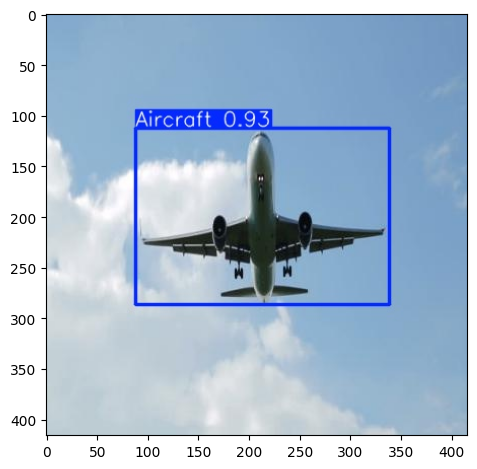

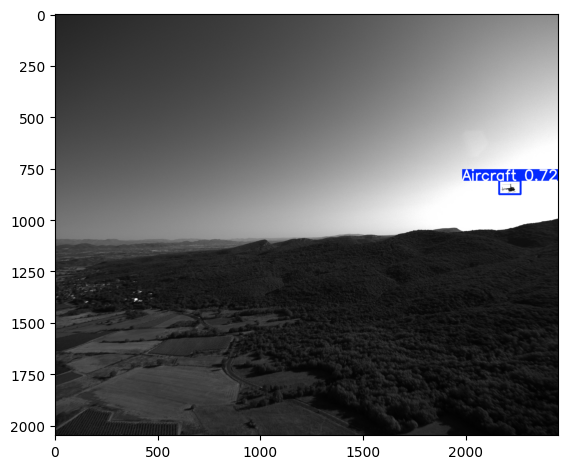

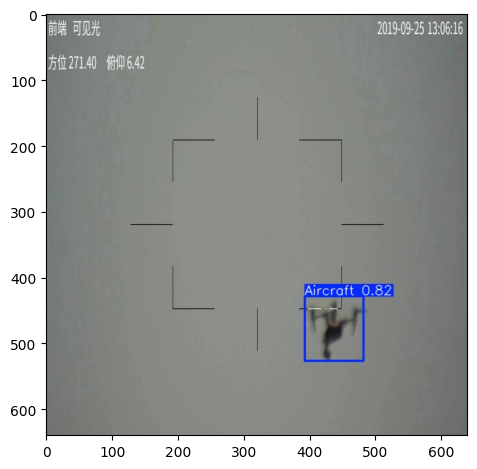

In [ ]:
import matplotlib.pyplot as plt
import cv2

image_list = ["airplane.jpg", "helicopter.png", "drone.jpg"]
results = model(image_list)
i=0
for result in results:
    result.show()
    result.save(f"detected_{image_list[i]}")
    image = cv2.cvtColor(cv2.imread(f"detected_{image_list[i]}"), cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(image)
    plt.tight_layout()
    plt.show()
    i+=1

Производительность алгоритма:

In [7]:
from calflops import calculate_flops

flops, macs, params = calculate_flops(model=model, input_shape=(1, 3, 640, 640))
print("%s FLOPs:%s  MACs:%s  Params:%s \n" %(model.model_name, flops, macs, params))


WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 12.089226722717285. Dividing input by 255.
0: 640x640 (no detections), 224.6ms
Speed: 0.0ms preprocess, 224.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  0       
fwd MACs:                                                               3.16 GMACs
fwd FLOPs:                                                              7.54 GFLOPS
fwd+bwd MACs:                     

In [2]:
!yolo task=detect mode=predict model= yolo11n-FlyingObjDet_ver5.pt verbose = False\
source='plane.avi'

Ultralytics 8.3.40 🚀 Python-3.13.2 torch-2.6.0+cpu CPU (12th Gen Intel Core(TM) i5-12450H)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
Results saved to runs\detect\predict53
💡 Learn more at https://docs.ultralytics.com/modes/predict


![alt text](gif_detected_plane.gif)

In [3]:
!yolo task=detect mode=predict model= yolo11n-FlyingObjDet_ver5.pt verbose = False\
source='helicopter.avi'

Ultralytics 8.3.40 🚀 Python-3.13.2 torch-2.6.0+cpu CPU (12th Gen Intel Core(TM) i5-12450H)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
Results saved to runs\detect\predict54
💡 Learn more at https://docs.ultralytics.com/modes/predict


![alt text](gif_detected_helicopter.gif)

Производительность алгоритма:

In [10]:
from calflops import calculate_flops

flops, macs, params = calculate_flops(model=model, input_shape=(1, 3, 544, 640))
print("%s FLOPs:%s  MACs:%s  Params:%s \n" %(model.model_name, flops, macs, params))


WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 9.345843315124512. Dividing input by 255.
0: 544x640 (no detections), 164.7ms
Speed: 0.1ms preprocess, 164.7ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  0       
fwd MACs:                                                               2.68 GMACs
fwd FLOPs:                                                              6.41 GFLOPS
fwd+bwd MACs:                      

In [11]:
model.info()

YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


(238, 2582347, 0, 6.3130112)

# Дополнительно

## Ракурс
Проанализировать какие ракурсы наиболее сложные для распознавания(ниже/выше горизонта; на фоне земли и т. д.)

### Вставка изображений

Возмем изображения без летательных аппаратов, где в кадре присутствуют небо и земля, и вырезаные летательные аппараты

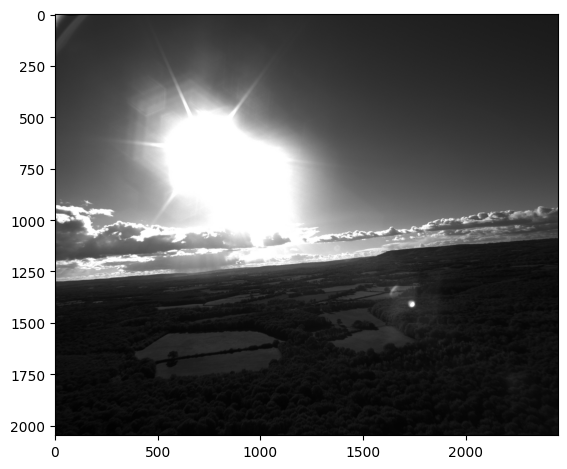

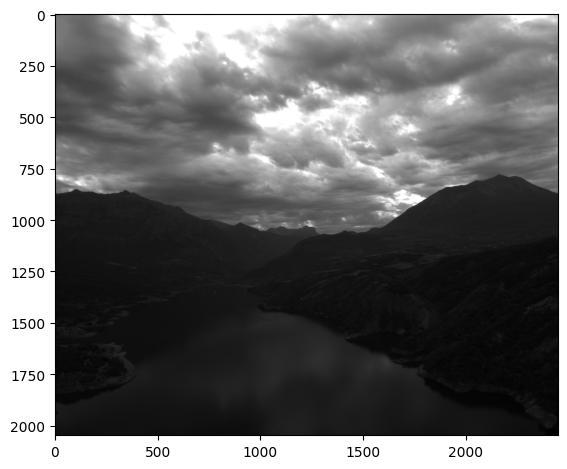

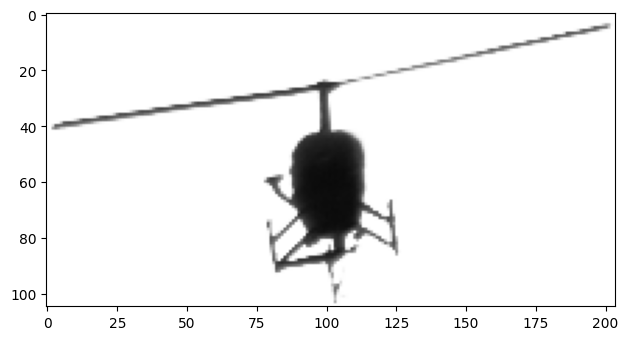

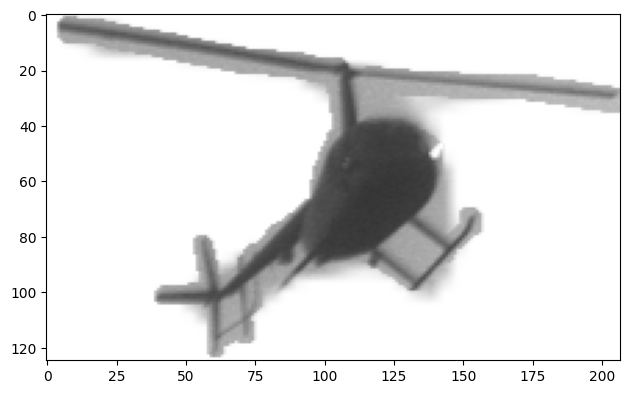

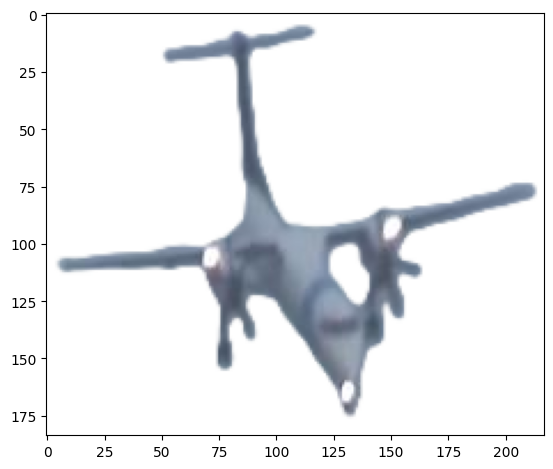

In [68]:
import matplotlib.pyplot as plt
import cv2

img_list = ["test_perspective.png","test_perspective2.png", "helicopter_crop.png", "helicopter_crop_2.png", "plane_crop.png"]
for img in img_list:
    image = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(image)
    plt.tight_layout()
    plt.show()

Найдем летательные аппараты от 16х16 до 100х100 пикселей для того, чтобы выявить самые сложные ракурсы для модели

In [ ]:
from PIL import Image
import cv2

def pasteImgInImg(path_img1 : str, path_img2 : str, model : YOLO, horizon_line : int):
    """
        Вставляет изображение 2 в изображение 1 несколько раз,
        детектирует моделью, сохраняет результат и отображает его

        :param path_img1: изображение, в которое нужно вставить (фон)
        :param path_img2: изображение, которое нужно вставить (детектируемый обьект)
        :param model: модель Yolo
        :param horizon_line: Координата y линии горизонта

        :return result_list: список с кол-вом детекций ниже и выше горизонта в зависимости от размера обьекта
    """
    result_list = []
    img2 = Image.open(path_img2) 
    img_size_list = [16, 32, 64, 80, 100]
    for img_size in img_size_list:
        print(f"Обьект размером ({img_size}, {img_size})")
        img1 = Image.open(path_img1) 
        img2 = img2.resize((img_size, img_size))
        j = 0
        while j in range(img1.size[1]):
            i = 0
            while i in range(img1.size[0]):
                img1.paste(img2, (i,j), mask = img2) 
                i +=500
            j += 500

        temp_dict = {"size":img_size, "above_horizon": 0, "below_horizon":0}
        results = model(img1)
        for result in results:
            for res in result.boxes.xyxy:
                if res[3] <= horizon_line: 
                    temp_dict["above_horizon"] +=1
                else:
                    temp_dict["below_horizon"] +=1
            result.save(f"size{img_size}_detected_{path_img1}")
            image = cv2.cvtColor(cv2.imread(f"size{img_size}_detected_{path_img1}"), cv2.COLOR_BGR2RGB)
            imgplot = plt.imshow(image)
            plt.tight_layout()
            plt.show()
        result_list.append(temp_dict)
    return result_list

Поставим линию горизанта для test_perspective с 1131, а для test_perspective2 - 782

Вертелет снят с нижнего/бокового ракурса:

Обьект размером (16, 16)

0: 544x640 1 Aircraft, 83.2ms
Speed: 4.1ms preprocess, 83.2ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


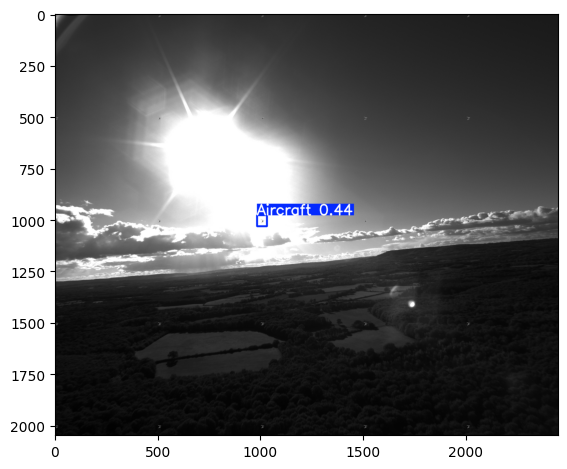

Обьект размером (32, 32)

0: 544x640 1 Aircraft, 82.4ms
Speed: 4.4ms preprocess, 82.4ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)


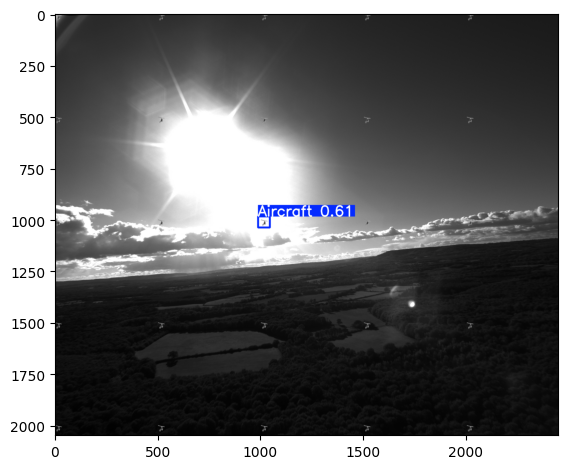

Обьект размером (64, 64)

0: 544x640 1 Aircraft, 79.5ms
Speed: 3.1ms preprocess, 79.5ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)


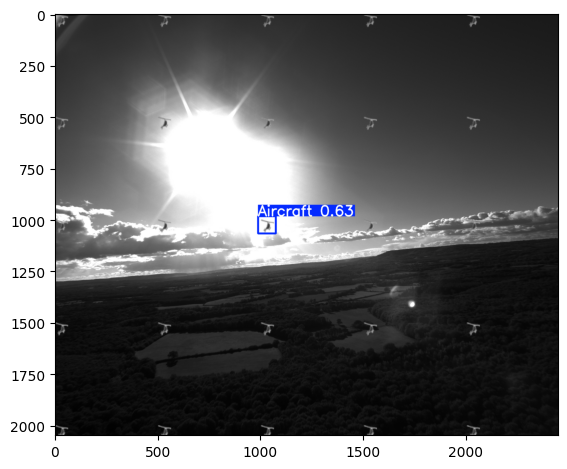

Обьект размером (80, 80)

0: 544x640 3 Aircrafts, 78.0ms
Speed: 3.1ms preprocess, 78.0ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


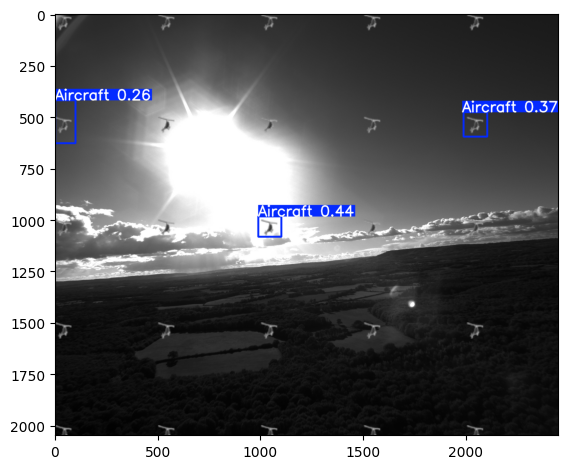

Обьект размером (100, 100)

0: 544x640 3 Aircrafts, 93.0ms
Speed: 3.2ms preprocess, 93.0ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


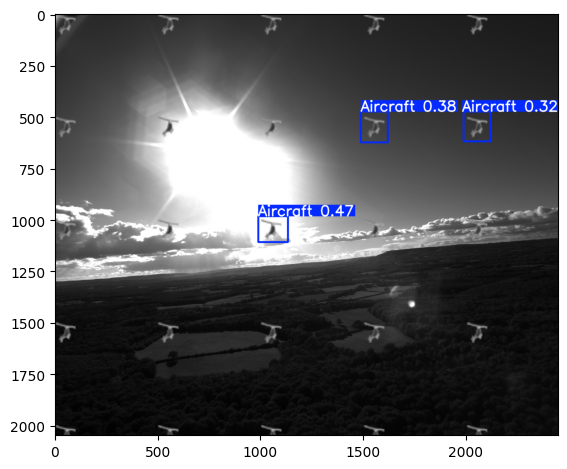

In [80]:
result_list = pasteImgInImg("test_perspective.png", "helicopter_crop_2.png", model, 1131)

In [81]:
result_list

[{'size': 16, 'above_horizon': 1, 'below_horizon': 0},
 {'size': 32, 'above_horizon': 1, 'below_horizon': 0},
 {'size': 64, 'above_horizon': 1, 'below_horizon': 0},
 {'size': 80, 'above_horizon': 3, 'below_horizon': 0},
 {'size': 100, 'above_horizon': 3, 'below_horizon': 0}]

Все найденные вертолеты находятся выше горизонта

Вертелет снят с фронтального ракурса:

Обьект размером (16, 16)

0: 544x640 (no detections), 88.3ms
Speed: 4.1ms preprocess, 88.3ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


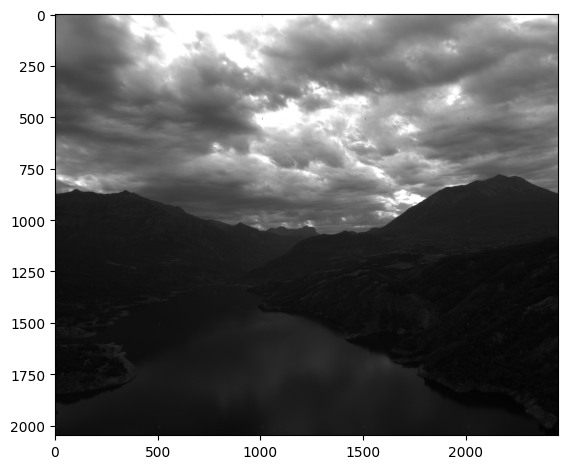

Обьект размером (32, 32)

0: 544x640 2 Aircrafts, 89.8ms
Speed: 3.4ms preprocess, 89.8ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


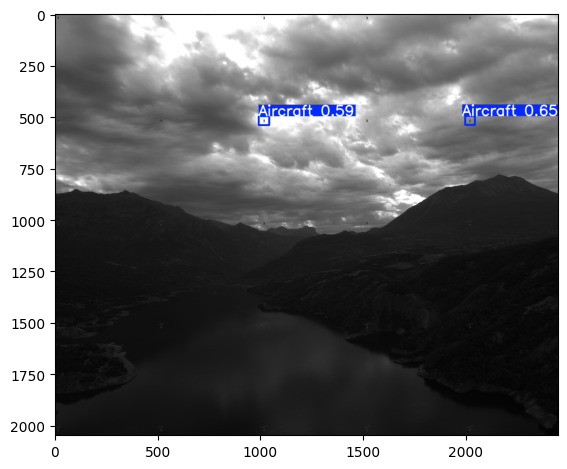

Обьект размером (64, 64)

0: 544x640 4 Aircrafts, 101.9ms
Speed: 4.0ms preprocess, 101.9ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


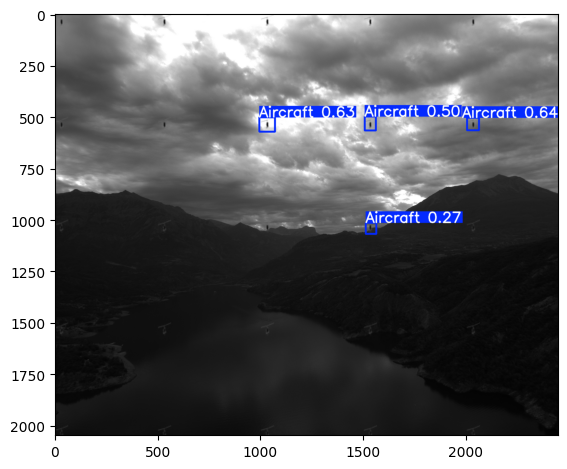

Обьект размером (80, 80)

0: 544x640 7 Aircrafts, 94.0ms
Speed: 3.5ms preprocess, 94.0ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


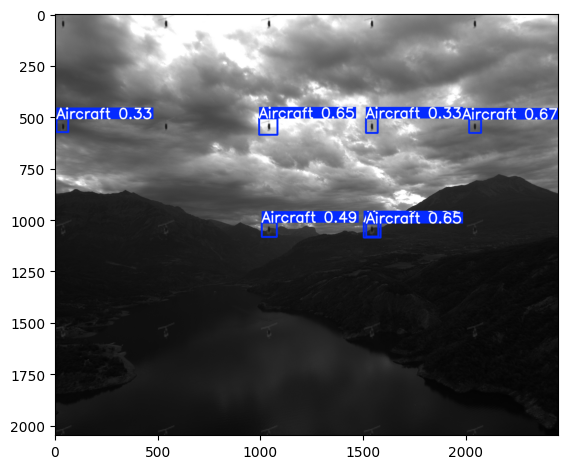

Обьект размером (100, 100)

0: 544x640 9 Aircrafts, 85.7ms
Speed: 3.5ms preprocess, 85.7ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


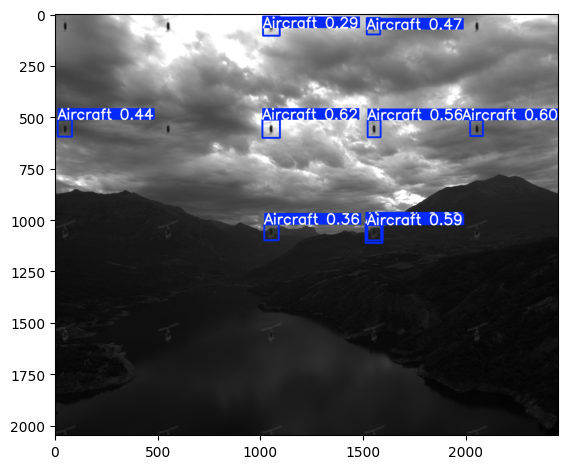

In [83]:
result_list = pasteImgInImg("test_perspective2.png", "helicopter_crop.png", model, 782)

In [84]:
result_list 

[{'size': 16, 'above_horizon': 0, 'below_horizon': 0},
 {'size': 32, 'above_horizon': 2, 'below_horizon': 0},
 {'size': 64, 'above_horizon': 3, 'below_horizon': 1},
 {'size': 80, 'above_horizon': 4, 'below_horizon': 3},
 {'size': 100, 'above_horizon': 6, 'below_horizon': 3}]

Большинство найденных вертолетов выше горозонта.

Обьект размером (16, 16)

0: 544x640 (no detections), 102.1ms
Speed: 4.7ms preprocess, 102.1ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


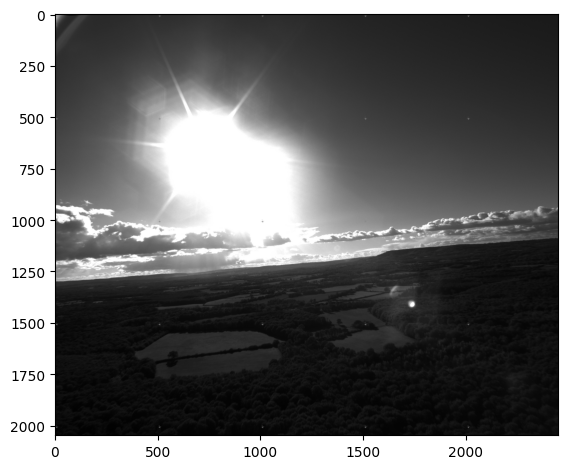

Обьект размером (32, 32)

0: 544x640 1 Aircraft, 102.9ms
Speed: 3.9ms preprocess, 102.9ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


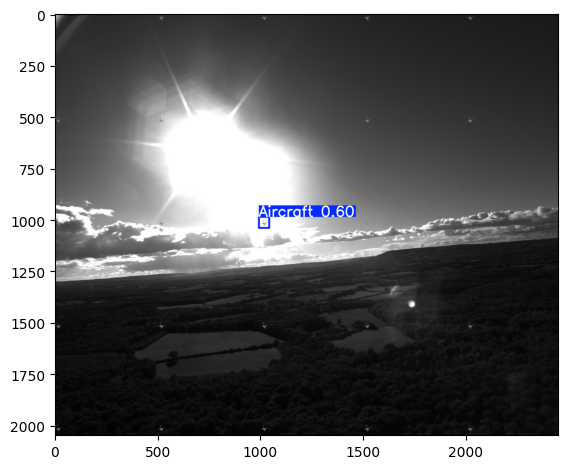

Обьект размером (64, 64)

0: 544x640 1 Aircraft, 90.4ms
Speed: 3.7ms preprocess, 90.4ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)


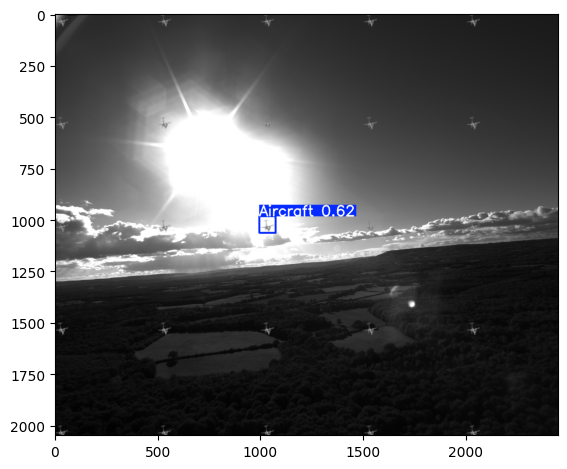

Обьект размером (80, 80)

0: 544x640 2 Aircrafts, 74.1ms
Speed: 3.9ms preprocess, 74.1ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


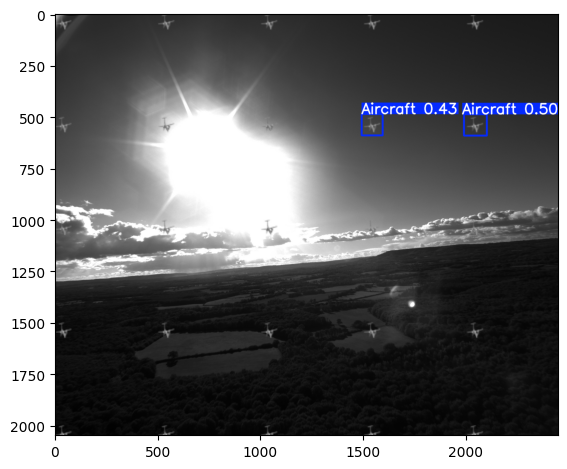

Обьект размером (100, 100)

0: 544x640 2 Aircrafts, 82.8ms
Speed: 4.0ms preprocess, 82.8ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)


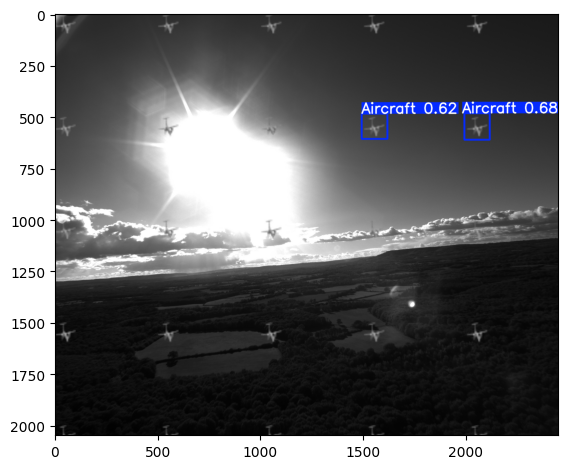

In [88]:
result_list = pasteImgInImg("test_perspective.png", "plane_crop.png", model, 1131)

In [89]:
result_list

[{'size': 16, 'above_horizon': 0, 'below_horizon': 0},
 {'size': 32, 'above_horizon': 1, 'below_horizon': 0},
 {'size': 64, 'above_horizon': 1, 'below_horizon': 0},
 {'size': 80, 'above_horizon': 2, 'below_horizon': 0},
 {'size': 100, 'above_horizon': 2, 'below_horizon': 0}]

Найденные самолеты находятся выше горозонта.

Большинство найденные летательных аппаратов находятся выше горизонта и в правой части изображения.

### Анализ видео

Ниже горизонта/на фоне земли:

In [ ]:
import cv2

def detectionPercentage(video_path: str, model : YOLO):
    """
        Находит процент детекции видео, сохраняет детекцию

        :param video_path: путь до видео
        :param model: модель Yolo
    """

    video = cv2.VideoCapture(video_path)
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    print('Кол-во кадров в видео:', frame_count)
    results = model(video_path, stream=True, save= True, verbose = False)

    num_of_detections = 0
    for result in results:
        num_of_detections += len(result.boxes.xyxy)
    print("Кол-во детекций в видео:", num_of_detections)
    print("Процент детекции обьекта в видео:", 100/(frame_count/num_of_detections))

In [ ]:
detectionPercentage('helicopter-3.avi', model)

Кол-во кадров в видео: 60
Results saved to runs\detect\predict55
Кол-во детекций в видео: 59
Процент детекции обьекта в видео: 98.33333333333334


![alt text](gif_detected_helicopter_2.gif)

На нескольких кадрах не найден вертолет. На некоторых кадрах на фоне земли возможна двойная детекция

На фоне горы уверенность в правильной детекции была ниже 50% несколько кадров

Ниже горизонта/на фоне земли/боковой ракурс:

In [102]:
detectionPercentage('helicopter-4.avi', model)

Кол-во кадров в видео: 90
Results saved to runs\detect\predict55
Кол-во детекций в видео: 90
Процент детекции обьекта в видео: 100.0


![alt text](gif_detected_helicopter_3.gif)

На одном кадре прерывается детекция, а на другом детектируется два обьекта

Выше горизонта:

In [103]:
detectionPercentage('drone.avi', model)

Кол-во кадров в видео: 38
Results saved to runs\detect\predict55
Кол-во детекций в видео: 38
Процент детекции обьекта в видео: 100.0


![alt text](gif_detected_drone.gif)

Детекция не прерывается

Нижний/боковой ракурс:

In [104]:
detectionPercentage('helicopter-5.avi', model)

Кол-во кадров в видео: 59
Results saved to runs\detect\predict55
Кол-во детекций в видео: 59
Процент детекции обьекта в видео: 100.0


![alt text](gif_detected_helicopter_4.gif)

Детекция не прерывается

----------------------
Худшие для распознования ракурсы:

Ниже горизонта/ на фоне земли

## Размер
Проанализировать какого размера объекты могут быть обнаружены, как это соотносится с реальным расстоянием до объекта

In [122]:
import os, os.path

DIRs = ["train\\images", "test\\images", "valid\\images"]
ext =(".jpg", ".png", ".gif")
dir_img = []
for dir in DIRs:
    dir_img.extend([os.path.join(dir, name) for name in os.listdir(dir) if os.path.isfile(os.path.join(dir, name)) and name.endswith(ext)])

In [123]:
area_list = []
for img in dir_img:
    results = model(img, stream=True, verbose = False)
    for result in results:
        boxes = result.boxes
        if boxes:
            length = float(boxes.xyxy[0][2]- boxes.xyxy[0][0])
            width = float(boxes.xyxy[0][3]- boxes.xyxy[0][1])
            area_list.append({"path":img, "size" : length * width})

Отсортируем лист

In [125]:
area_list = sorted(area_list, key=lambda d: d['size'])

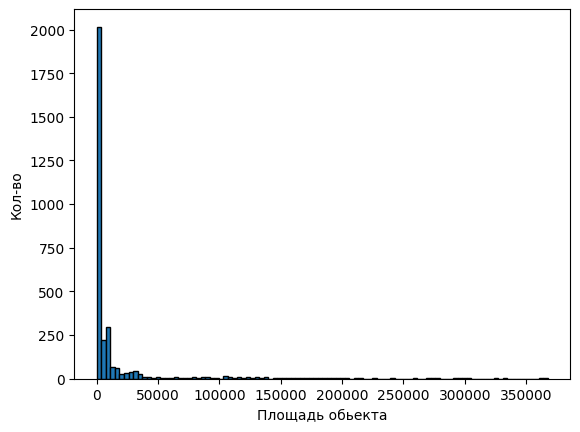

In [133]:
import matplotlib.pyplot as plt

plt.hist([x['size'] for x in area_list], bins=100, edgecolor='black')
plt.xlabel('Площадь обьекта')
plt.ylabel('Кол-во')
plt.show()

Посмотрим начало списка

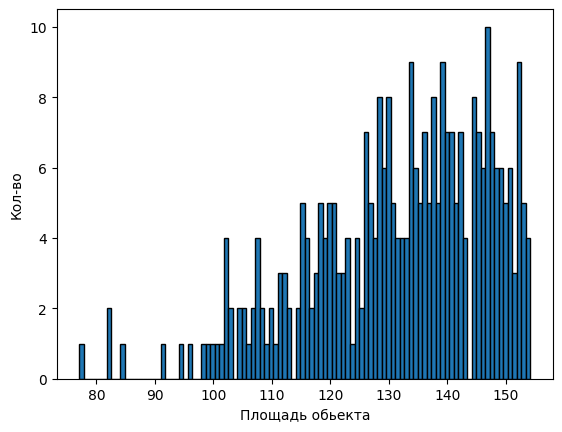

In [134]:
import matplotlib.pyplot as plt

plt.hist([x['size'] for x in area_list][:len([x['size'] for x in area_list]) // 10], bins=100, edgecolor='black')
plt.xlabel('Площадь обьекта')
plt.ylabel('Кол-во')
plt.show()

Топ 5 самых маленьких(по площади) найденных обьектов:
Размер обьекта: 77.09352437406778


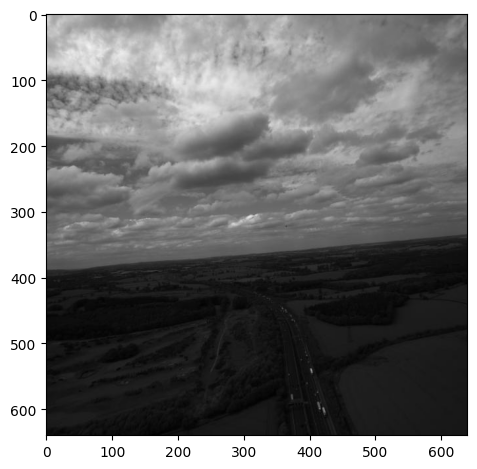

Размер обьекта: 81.7652813270688


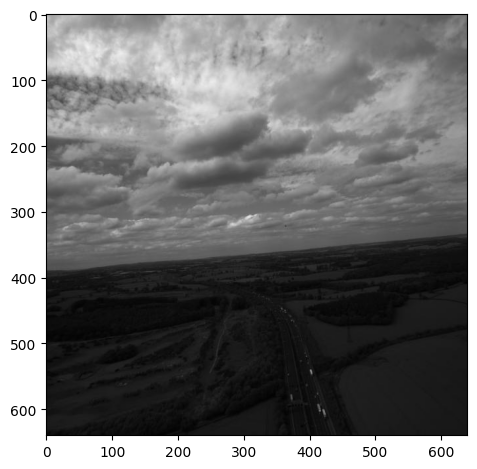

Размер обьекта: 81.8073882162571


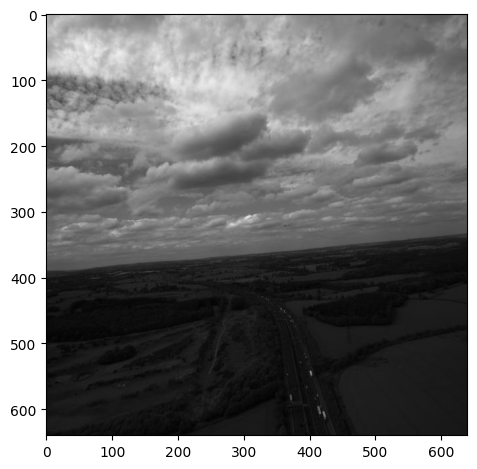

Размер обьекта: 84.03789438307285


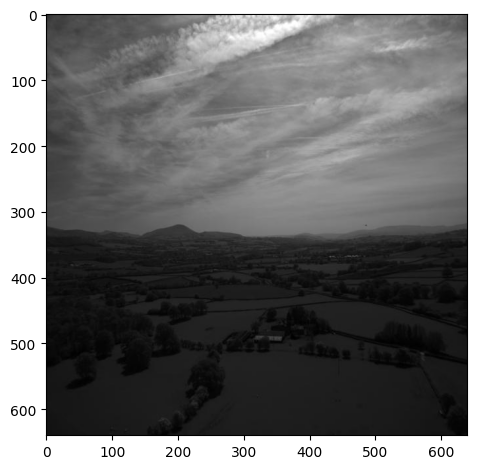

Размер обьекта: 91.11045844852924


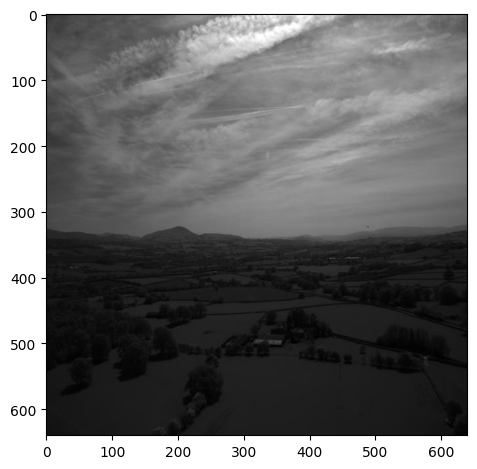

In [146]:
import matplotlib.pyplot as plt
import cv2

print("Топ 5 самых маленьких(по площади) найденных обьектов:")
for el in area_list[:5]:
    print("Размер обьекта:", el["size"])
    image = cv2.cvtColor(cv2.imread(el["path"]), cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(image)
    plt.tight_layout()
    plt.show()

Топ 5 самых больших(по площади) найденных обьектов:
Размер обьекта: 366576.48261894286


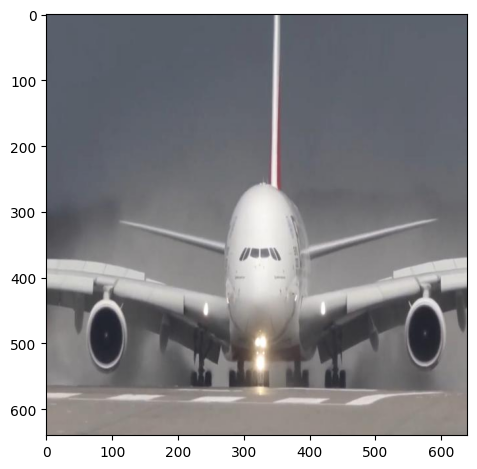

Размер обьекта: 366628.2422249764


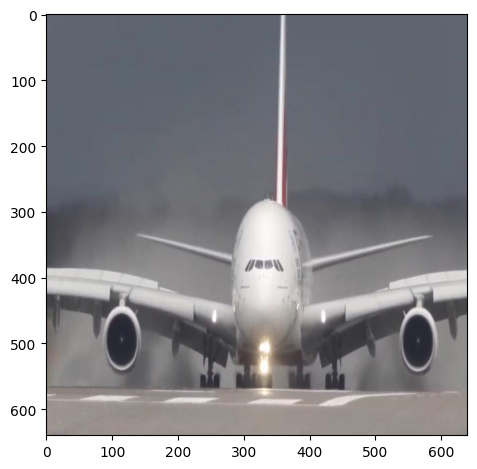

Размер обьекта: 366727.19459432364


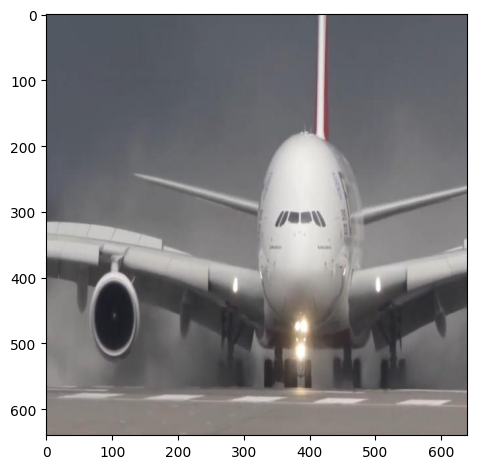

Размер обьекта: 367231.5004134625


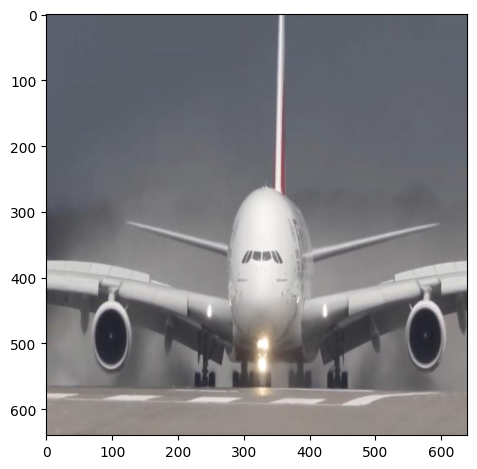

Размер обьекта: 367743.7172393203


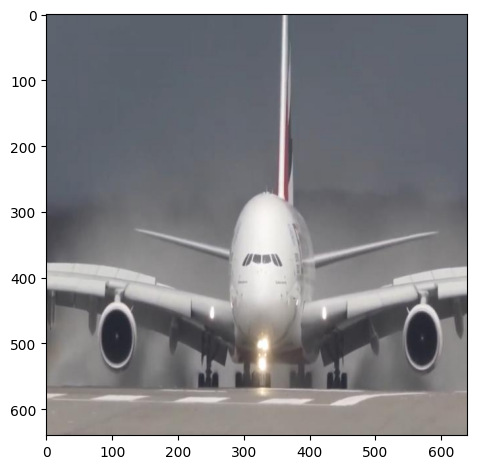

In [147]:
import matplotlib.pyplot as plt
import cv2

print("Топ 5 самых больших(по площади) найденных обьектов:")
for el in area_list[-5:]:
    print("Размер обьекта:", el["size"])
    image = cv2.cvtColor(cv2.imread(el["path"]), cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(image)
    plt.tight_layout()
    plt.show()